## ETL

In [1]:
import pandas as pd
import numpy as np

from ydata_profiling import ProfileReport

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set()
import warnings
warnings.filterwarnings('ignore')

Primero, voy a leer el dataset

In [89]:
df=pd.read_csv('Datasets/AccidentesAviones.csv',index_col=0)

In [3]:
df.head()

fecha HORA declarada                                Ruta  \
0  September 17, 1908           1718                 Fort Myer, Virginia   
1  September 07, 1909              ?             Juvisy-sur-Orge, France   
2       July 12, 1912           0630           Atlantic City, New Jersey   
3     August 06, 1913              ?  Victoria, British Columbia, Canada   
4  September 09, 1913           1830                  Over the North Sea   

                 OperadOR flight_no          route                 ac_type  \
0    Military - U.S. Army         ?  Demonstration        Wright Flyer III   
1                       ?         ?       Air show          Wright Byplane   
2    Military - U.S. Navy         ?    Test flight               Dirigible   
3                 Private         ?              ?        Curtiss seaplane   
4  Military - German Navy         ?              ?  Zeppelin L-1 (airship)   

  registration cn_ln all_aboard PASAJEROS A BORDO crew_aboard  \
0            ?     1          2                 1           1   
1          SC1     ?          1                 0           1   
2            ?     ?          5                 0           5   
3            ?     ?          1                 0           1   
4            ?     ?         20                 ?           ?   

  cantidad de fallecidos passenger_fatalities crew_fatalities ground  \
0                      1                    1               0      0   
1                      1                    0               0      0   
2                      5                    0               5      0   
3                      1                    0               1      0   
4                     14                    ?               ?      0   

                                             summary  
0  During a demonstration flight, a U.S. Army fly...  
1  Eugene Lefebvre was the first pilot to ever be...  
2  First U.S. dirigible Akron exploded just offsh...  
3  The first fatal airplane accident in Canada oc...  
4  The airship flew into a thunderstorm and encou...

Muchas columnas del dataset tienen valores '?', los cuales asumiré que corresponden a valores nulos porque, como vemos a continuación, realmente no hay valores que pandas haya interpretado como NaN. 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5008 entries, 0 to 5007
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   fecha                   5008 non-null   object
 1   HORA declarada          5008 non-null   object
 2   Ruta                    5008 non-null   object
 3   OperadOR                5008 non-null   object
 4   flight_no               5008 non-null   object
 5   route                   5008 non-null   object
 6   ac_type                 5008 non-null   object
 7   registration            5008 non-null   object
 8   cn_ln                   5008 non-null   object
 9   all_aboard              5008 non-null   object
 10  PASAJEROS A BORDO       5008 non-null   object
 11  crew_aboard             5008 non-null   object
 12  cantidad de fallecidos  5008 non-null   object
 13  passenger_fatalities    5008 non-null   object
 14  crew_fatalities         5008 non-null   object
 15  grou

Ahora, lo primero que haré es reemplazar todos los valores que aparecen como '?' por NaN y luego voy a eliminar las columnas que de entrada creo que no me van a servir para nada: el número del vuelo, registro, cn_ln (que parece ser algun número de serie) y summary, que es una descripción del evento.

In [90]:
df.replace('?',np.nan,inplace=True)

In [91]:
df.drop(columns=['flight_no','registration','cn_ln','summary'],inplace=True)

Ahora, voy a revisar nuevamente la cantidad de valores nulos

In [92]:
df.isna().sum()

fecha                        0
HORA declarada            1504
Ruta                         5
OperadOR                    10
route                      762
ac_type                     13
all_aboard                  17
PASAJEROS A BORDO          221
crew_aboard                219
cantidad de fallecidos       8
passenger_fatalities       235
crew_fatalities            235
ground                      44
dtype: int64

Voy a eliminar los datos nulos de cantidad de fallecidos, ya que me interesa hacer un análisis de la tasa de mortalidad y si hay registros que no tienen ese dato, no me van a ser de mucha utilidad.

In [8]:
df.dropna(subset='cantidad de fallecidos',inplace=True)

In [9]:
df=df.reset_index(drop=True)

Ahora, veo que las columnas estan horriblemente escritas, voy a poner todos esos nombres en minúsculas.

In [10]:
df.columns= df.columns.str.lower()

Tengo un campo de fecha que realmente no me sirve en el análisis porque es un string, así que voy a cambiarle el formato y dejarlo en formato YYYY-MM-DD. Primero, voy a separar los datos por los espacios y los voy a asignar a nuevas columnas en el dataframe.

In [11]:
df[['mes','dia','anio']]=df['fecha'].str.split(' ', expand=True)

Ahora, ya que tengo esto, tengo que cambiar el formato de los días que quedaron con una coma al final. Para estoy voy a reemplazar la coma con un valor vacío.

In [12]:
df['dia']=df.dia.str.replace(',','')

Ahora, en la columna mes voy a reemplazar el mes por el número representativo de cada mes. 

In [13]:
df['mes']=pd.to_datetime(df['mes'], format='%B').dt.month

Ahora asignaré a la columna fecha la combinación de las columnas anio, mes y día y quitaré estas columnas, dejando solo la columna de fecha.

In [14]:
df['fecha']=df['anio'].astype(str)+'-'+df['mes'].astype(str)+'-'+df['dia'].astype(str)

In [15]:
df.drop(columns=['mes','dia','anio'],inplace=True)

In [16]:
df.head()

fecha hora declarada                                ruta  \
0  1908-9-17           1718                 Fort Myer, Virginia   
1  1909-9-07            NaN             Juvisy-sur-Orge, France   
2  1912-7-12           0630           Atlantic City, New Jersey   
3  1913-8-06            NaN  Victoria, British Columbia, Canada   
4  1913-9-09           1830                  Over the North Sea   

                 operador          route                 ac_type all_aboard  \
0    Military - U.S. Army  Demonstration        Wright Flyer III          2   
1                     NaN       Air show          Wright Byplane          1   
2    Military - U.S. Navy    Test flight               Dirigible          5   
3                 Private            NaN        Curtiss seaplane          1   
4  Military - German Navy            NaN  Zeppelin L-1 (airship)         20   

  pasajeros a bordo crew_aboard cantidad de fallecidos passenger_fatalities  \
0                 1           1                      1                    1   
1                 0           1                      1                    0   
2                 0           5                      5                    0   
3                 0           1                      1                    0   
4               NaN         NaN                     14                  NaN   

  crew_fatalities ground  
0               0      0  
1               0      0  
2               5      0  
3               1      0  
4             NaN      0

In [17]:
df.isna().sum()

fecha                        0
hora declarada            1496
ruta                         5
operador                    10
route                      755
ac_type                     11
all_aboard                   9
pasajeros a bordo          213
crew_aboard                211
cantidad de fallecidos       0
passenger_fatalities       227
crew_fatalities            227
ground                      36
dtype: int64

Ahora, para mi análisis quisiera revisar solo los vuelos que tenian personas abordo, así que voy a eliminar los registros que no tienen porque creo que hay informacion inconsistente. 

In [18]:
df[df['all_aboard']=='0']

fecha hora declarada                                 ruta  \
30    1919-10-20            NaN  English Channel off Forkstone, Kent   
119    1927-1-12            NaN                     Estaires, France   
1114   1949-7-13            NaN       Jamnagar, Gujarat state, India   
3136   1981-9-22        c 12:00                Near Babaeski, Turkey   
3368   1986-3-27            NaN     Bangui, Central African Republic   

                           operador            route            ac_type  \
30    Aircraft Transport and Travel              NaN  De Havilland DH-4   
119                          Fokker  Delivery flight       Fokker F-VII   
1114               Indian Air Force         Training      Hawker Hunter   
3136   Military - Turkish Air Force              NaN      Northrop F-5A   
3368    Military - French Air Force              NaN   Sepecat Jaguar A   

     all_aboard pasajeros a bordo crew_aboard cantidad de fallecidos  \
30            0                 0           1                      0   
119           0                 0           2                      0   
1114          0                 1           1                      0   
3136          0                 0           0                      0   
3368          0                 0           0                      0   

     passenger_fatalities crew_fatalities ground  
30                      0               0      0  
119                     0               2      0  
1114                    1               1     14  
3136                    0               0     40  
3368                    0               0     35

In [19]:
df=df[df['all_aboard']!='0']

In [20]:
df=df.reset_index(drop=True)

Ahora, me di cuenta mirando los vuelos que no tuvieron fatalidades que la columna route parece no tener informacion consistente, unos valores parecen ser el tipo de vuelo que se estaba haciendo y otros el destino al que queria llegar el vuelo, quiero revisar esto mas a fondo. 

In [21]:
df['route']

0                      Demonstration
1                           Air show
2                        Test flight
3                                NaN
4                                NaN
                    ...             
4990             Sightseeing Charter
4991                             NaN
4992            Naypyidaw - Anisakan
4993    Cagayan de Oro-Lumbia - Jolo
4994          Petropavlovsk - Palana
Name: route, Length: 4995, dtype: object

Lo ultimo que veo, son nombres de ciudades y al comienzo el tipo de vuelo, voy a eliminar esta columna porque me parece inconsistente.

In [22]:
df.drop(columns='route',inplace=True)

In [23]:
df.head()

fecha hora declarada                                ruta  \
0  1908-9-17           1718                 Fort Myer, Virginia   
1  1909-9-07            NaN             Juvisy-sur-Orge, France   
2  1912-7-12           0630           Atlantic City, New Jersey   
3  1913-8-06            NaN  Victoria, British Columbia, Canada   
4  1913-9-09           1830                  Over the North Sea   

                 operador                 ac_type all_aboard  \
0    Military - U.S. Army        Wright Flyer III          2   
1                     NaN          Wright Byplane          1   
2    Military - U.S. Navy               Dirigible          5   
3                 Private        Curtiss seaplane          1   
4  Military - German Navy  Zeppelin L-1 (airship)         20   

  pasajeros a bordo crew_aboard cantidad de fallecidos passenger_fatalities  \
0                 1           1                      1                    1   
1                 0           1                      1                    0   
2                 0           5                      5                    0   
3                 0           1                      1                    0   
4               NaN         NaN                     14                  NaN   

  crew_fatalities ground  
0               0      0  
1               0      0  
2               5      0  
3               1      0  
4             NaN      0

Veo que la columna hora declarada tampoco tiene un formato uniforme, voy a normalizarla poniendo todos los valores como 4 numeros consecutivos. Como se que los datos estan en formato string, voy a filtrar los datos por los que tienen mas de 4 caracteres y usar replace para reemplazar por vacios los caracteres que no quiero.

In [24]:
df[df['hora declarada'].str.len()>4]

fecha hora declarada                                     ruta  \
83     1923-9-14        c 18:00  Near Ivinghoe, Buckinghamshire, England   
86    1923-12-23        c 02:30               Over the Mediterranean Sea   
94    1924-12-24        c 12:00                          Purley, England   
115   1926-10-21        c 13:15                          English Channel   
129    1927-9-23          10:00                         Schleiz, Germany   
...          ...            ...                                      ...   
4367   2002-2-22          02:30               Off Dumaguete, Philippines   
4372   2002-4-15          11:23                       Busan, South Korea   
4518  2004-12-11          05:30                          Uberaba, Brazil   
4729   2009-8-26          0500Z                    Nganga Lingolo, Congo   
4993   2021-7-04          11:30               Patikul, Sulu, Philippines   

                             operador                      ac_type all_aboard  \
83                    Daimler Airways           de Havilland DH-34          5   
86             Military - French Navy  Zeppelin Dixmunde (airship)         52   
94                   Imperial Airways          de Havilland DH-34B          8   
115                  Imperial Airways            Handley Page W-10         12   
129                Deutsche Lufthansa               Dornier Merkur          6   
...                               ...                          ...        ...   
4367             Military - U.S. Army     MH-47 Chinook helicopter         10   
4372                        Air China           Boeing B-767-200ER        166   
4518                   NHR Táxi-Aéreo  Embraer EMB-110 Bandeirante          2   
4729               Aero Fret Business              Antonov An-12BK          7   
4993  Military - Philippine Air Force     Lockheed C-130H Hercules         96   

     pasajeros a bordo crew_aboard cantidad de fallecidos  \
83                   3           2                      5   
86                 NaN         NaN                     52   
94                   7           1                      8   
115                 10           2                      0   
129                  4           2                      6   
...                ...         ...                    ...   
4367                 4           6                     10   
4372               155          11                    128   
4518                 0           2                      2   
4729                 2           5                      7   
4993                88           8                     50   

     passenger_fatalities crew_fatalities ground  
83                      3               2      0  
86                    NaN             NaN      0  
94                      7               1      0  
115                     0               0      0  
129                     4               2      0  
...                   ...             ...    ...  
4367                    4               6      0  
4372                  120               8      0  
4518                    0               2      1  
4729                    2               5      0  
4993                  NaN             NaN      3  

[211 rows x 12 columns]

In [25]:
df['hora declarada']=df['hora declarada'].str.replace(':','')

In [26]:
df['hora declarada']=df['hora declarada'].str.replace('c','')

Estos datos a los que le quite la c tienen un espacio antes de la hora, se lo quitare con la funcion strip.

In [27]:
df['hora declarada']=df['hora declarada'].str.strip()

Reviso nuevamente que datos me quedan por normalizar.

In [28]:
df[df['hora declarada'].str.len()>4]

fecha hora declarada                   ruta  \
872    1946-8-20          06;15          Rouen, France   
917   1946-12-28          0209Z  Near Shannon, Ireland   
1111   1949-7-12          0350Z     Near Bombay, India   
1298   1952-2-16          1734Z     Near Burgio, Italy   
1330   1952-8-21          0100Z     Off Trapani, Italy   
4729   2009-8-26          0500Z  Nganga Lingolo, Congo   

                               operador                             ac_type  \
872            British Overseas Airways              Avro 691 Lancastrian 1   
917   Trans Continental and Western Air           Lockheed 049 Consellation   
1111           KLM Royal Dutch Airlines  Lockheed L-749-79-33 Constellation   
1298                 Hunting Air Travel                Vickers 614 Viking 1   
1330                            Airwork        Handley Page HP-81 Hermes 4A   
4729                 Aero Fret Business                     Antonov An-12BK   

     all_aboard pasajeros a bordo crew_aboard cantidad de fallecidos  \
872           9                 0           9                      8   
917          23                14           9                     13   
1111         45                34          11                     45   
1298         31                26           5                     31   
1330         57                51           6                      7   
4729          7                 2           5                      7   

     passenger_fatalities crew_fatalities ground  
872                     0               8      0  
917                     9               4      0  
1111                   34              11      0  
1298                   26               5      0  
1330                    1               6      0  
4729                    2               5      0

In [29]:
df['hora declarada']=df['hora declarada'].str.replace('Z','')

In [30]:
df['hora declarada']=df['hora declarada'].str.replace(';','')

Compruebo que no queden datos por normalizar y cuento nuevamente cuantos valores nulos hay para tener en cuenta cuando convierta a formato hora que no me aparezcan mas valores nulos.

In [31]:
df[df['hora declarada'].str.len()>4]

Empty DataFrame
Columns: [fecha, hora declarada, ruta, operador, ac_type, all_aboard, pasajeros a bordo, crew_aboard, cantidad de fallecidos, passenger_fatalities, crew_fatalities, ground]
Index: []

In [32]:
df['hora declarada'].isna().sum()

1492

Ahora, para comparar valores, voy a poner en una nueva columna auxiliar la hora con el formato de tiempo por si me aparecen mas valores NaN cuando convierta.

In [33]:
df['hora']=pd.to_datetime(df['hora declarada'], format='%H%M').dt.time

In [34]:
df.hora.isna().sum()

1492

Me dio el mismo numero asi que la transformacion fue satisfactoria. Voy a reasignar a la columna hora declarada los valores de la columna auxiliar hora y despues la eliminaré. 

In [35]:
df['hora declarada']=df['hora']
df.drop(columns=['hora'],inplace=True)

In [36]:
df.head()

fecha hora declarada                                ruta  \
0  1908-9-17       17:18:00                 Fort Myer, Virginia   
1  1909-9-07            NaT             Juvisy-sur-Orge, France   
2  1912-7-12       06:30:00           Atlantic City, New Jersey   
3  1913-8-06            NaT  Victoria, British Columbia, Canada   
4  1913-9-09       18:30:00                  Over the North Sea   

                 operador                 ac_type all_aboard  \
0    Military - U.S. Army        Wright Flyer III          2   
1                     NaN          Wright Byplane          1   
2    Military - U.S. Navy               Dirigible          5   
3                 Private        Curtiss seaplane          1   
4  Military - German Navy  Zeppelin L-1 (airship)         20   

  pasajeros a bordo crew_aboard cantidad de fallecidos passenger_fatalities  \
0                 1           1                      1                    1   
1                 0           1                      1                    0   
2                 0           5                      5                    0   
3                 0           1                      1                    0   
4               NaN         NaN                     14                  NaN   

  crew_fatalities ground  
0               0      0  
1               0      0  
2               5      0  
3               1      0  
4             NaN      0

In [37]:
df.isna().sum()

fecha                        0
hora declarada            1492
ruta                         5
operador                    10
ac_type                     11
all_aboard                   9
pasajeros a bordo          213
crew_aboard                211
cantidad de fallecidos       0
passenger_fatalities       227
crew_fatalities            227
ground                      36
dtype: int64

Ahora, tampoco puedo calcular la tasa de mortalidad si no se cuantas personas iban a bordo en total, voy a revisar los registros de esta columna que aparecen como NaN.

In [38]:
df[df.all_aboard.isna()]

fecha hora declarada                                     ruta  \
26     1919-7-21       16:55:00                        Chicago, Illinois   
1221   1951-1-20            NaT                             Huilyo, Peru   
1352  1952-12-22            NaT                          Damascus, Syria   
1376   1953-4-10            NaT             Near Anchieta Island, Brazil   
1566   1956-6-13            NaT                      Over North Carolina   
1616   1957-4-20            NaT                            Jirkouk, Iraq   
1627   1957-6-24            NaT       Horn Island, Queensland, Australia   
3540   1989-5-09            NaT                      Near Tainjin, China   
3739   1992-2-20            NaT  En route from Argentina  to  California   

                                operador                       ac_type  \
26    Wingfoot Air Express Goodyear Tire             FD Type Dirigible   
1221                      Military - TAM                  Douglas DC-3   
1352                          Syrian Air                  Douglas DC-3   
1376                                REAL                  Doublas Dc-3   
1566                            Piedmont                  Douglas DC-3   
1616                          Air France  Lockheed Super Constellation   
1627                     Adastra Airways                      L-Hudson   
3540                          Aero Asahi                      Bell 412   
3739               Aerolineas Argentinas                  Boeing B-747   

     all_aboard pasajeros a bordo crew_aboard cantidad de fallecidos  \
26          NaN               NaN         NaN                      3   
1221        NaN               NaN         NaN                     16   
1352        NaN               NaN         NaN                      9   
1376        NaN               NaN         NaN                     26   
1566        NaN               NaN         NaN                      1   
1616        NaN               NaN         NaN                      1   
1627        NaN               NaN         NaN                      6   
3540        NaN               NaN         NaN                     10   
3739        NaN               NaN         NaN                      1   

     passenger_fatalities crew_fatalities ground  
26                      2               1     10  
1221                  NaN             NaN    NaN  
1352                  NaN             NaN    NaN  
1376                  NaN             NaN    NaN  
1566                    1             NaN      0  
1616                    1               0      0  
1627                  NaN             NaN    NaN  
3540                  NaN             NaN      0  
3739                  NaN             NaN      0

Realmente no tengo manera de saber cuantas personas en total iban a bordo asi que voy a eliminar estos registros. 

In [39]:
df.dropna(subset='all_aboard',inplace=True)

In [40]:
df=df.reset_index(drop=True)

In [41]:
df['fecha']=pd.to_datetime(df['fecha'],format='%Y-%m-%d',errors='coerce')

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4986 entries, 0 to 4985
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   fecha                   4986 non-null   datetime64[ns]
 1   hora declarada          3502 non-null   object        
 2   ruta                    4981 non-null   object        
 3   operador                4976 non-null   object        
 4   ac_type                 4975 non-null   object        
 5   all_aboard              4986 non-null   object        
 6   pasajeros a bordo       4782 non-null   object        
 7   crew_aboard             4784 non-null   object        
 8   cantidad de fallecidos  4986 non-null   object        
 9   passenger_fatalities    4765 non-null   object        
 10  crew_fatalities         4766 non-null   object        
 11  ground                  4954 non-null   object        
dtypes: datetime64[ns](1), object(11)
memory usage: 4

Voy a renombrar las columnas para que queden todas en español.

In [43]:
df.rename(columns={'ac_type':'tipo_aeronave', 'hora declarada':'hora_declarada','all_aboard':'total_abordo',
                   'pasajeros a bordo':'pasajeros_abordo','crew_aboard': 'tripulacion_abordo', 'cantidad de fallecidos':'total_fatalidades',
                   'passenger_fatalities':'pasajeros_fatalidades', 'crew_fatalities':'tripulacion_fatalidades', 'ground':'tierra_fatalidades'
}, inplace=True)

In [44]:
df.isna().sum()

fecha                         0
hora_declarada             1484
ruta                          5
operador                     10
tipo_aeronave                11
total_abordo                  0
pasajeros_abordo            204
tripulacion_abordo          202
total_fatalidades             0
pasajeros_fatalidades       221
tripulacion_fatalidades     220
tierra_fatalidades           32
dtype: int64

In [45]:
df['pasajeros_abordo'].loc[df['pasajeros_abordo'].isna() & df['tripulacion_abordo'].notna()]=df['pasajeros_abordo'].loc[df['pasajeros_abordo'].isna() & df['tripulacion_abordo'].notna()].fillna(0)

In [46]:
df['tripulacion_abordo'].loc[df['pasajeros_abordo'].notna() & df['tripulacion_abordo'].isna()]=df['tripulacion_abordo'].loc[df['pasajeros_abordo'].notna() & df['tripulacion_abordo'].isna()].fillna(0)

In [47]:
df['pasajeros_fatalidades'].loc[df['pasajeros_fatalidades'].isna() & df['tripulacion_fatalidades'].notna()]=df['pasajeros_fatalidades'].loc[df['pasajeros_fatalidades'].isna() & df['tripulacion_fatalidades'].notna()].fillna(df['total_fatalidades'].astype(float)-df['tripulacion_fatalidades'].astype(float))

In [48]:
df['tripulacion_fatalidades'].loc[df['pasajeros_fatalidades'].notna() & df['tripulacion_fatalidades'].isna()]=df['tripulacion_fatalidades'].loc[df['pasajeros_fatalidades'].notna() & df['tripulacion_fatalidades'].isna()].fillna(df['total_fatalidades'].astype(float)-df['pasajeros_fatalidades'].astype(float))

## EDA

Para efectos del análisis voy a agregar una columna auxiliar con el año del accidente.

In [49]:
df['anio']=df['fecha'].dt.year

In [50]:
ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

ANÁLISIS DEL REPORTE

columna: fecha 


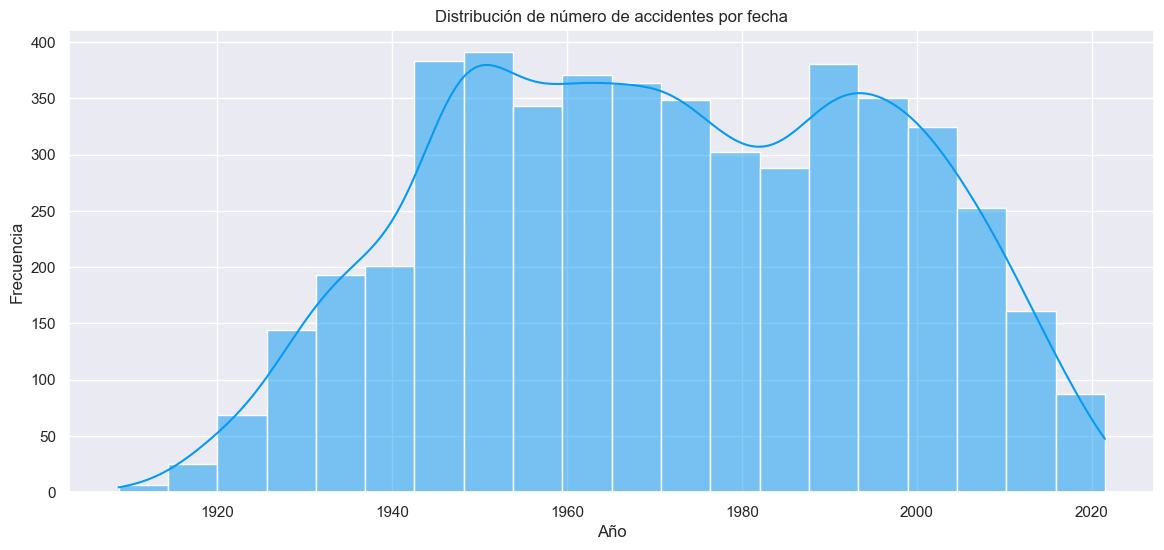

In [51]:
plt.figure(figsize=(14, 6))
sns.histplot(data=df, x='fecha', bins=20, color='xkcd:azure',kde=True)
plt.xlabel('Año')
plt.ylabel('Frecuencia')
plt.title('Distribución de número de accidentes por fecha')
plt.show()

Según el reporte y esta gráfica, vemos que despues de 1940 y antes de los 2000, tenemos la mayor concentración de accidentes aereos con fatalidades. Según el reporte, en este dataset, el top 10 de años con más accidentes fatales fueron todos antes de 1995, teniendo el pico máximo en el año 1946. Esto, en teoria tiene sentido si tenemos en cuenta que la aviación comercial se empezó a dar alrededor del año 1914(cita1) y creció notoriamente en popularidad a partir los años 50(cita2). Esto significa que alrededor de las fechas donde tenemos nuestros máximos, habian más aeronaves volando con pasajeros a bordo que en los años previos. Sumandole a esto, es conocido que la primera generación de jets(1952 hasta 1964) tenian una alta tasa de accidentalidad, en gran parte porque las prácticas de mantenimiento para las aeronaves eran inadecuadas. De aquí, que desde 1960 se desarrollara una investigación exhaustiva para mejorar esta situación, en cabeza de United Airlines y respaldada por el departamento de defensa de Estados Unidos, la cual en 1978 dio sus frutos generando los nuevos estandares de mantenimiento que se debian seguir en la aviación para garantizar la confiabilidad de las maquinas(hasta hoy en día este estandar se mantiene y se ha convertido en el estandar de mantenimiento para muchos otros sectores más internacionalmente)(cita3). La aplicación de esta nueva metodología fue exitosa en disminuir los niveles de accidentalidad en los años siguientes, cuando finalmente se vuelve un estandar internacional y se empieza a usar ampliamente. 

columnas: ruta y operador

Para esta columna, segun el reporte, la mayor cantidad de accidentes se han dado en la ruta a Moscú, Rusia. Adelantandome un poco, esto tiene sentido con la columna operador, ya que la mayor cantidad de accidentes aereos en este dataset corresponden a Aeroflot, una aerolinea rusa que fue fundada en 1923 (cita4). Según las estadisticas, Aeroflot ha tenido cinco veces más accidentes que cualquier otra aerolinea, sobretodo en el tiempo de la unión sovietica. En este dataset, hay mas accidentes registrados para Aeroflot que para las fuerzas aereas de cualquier pais incluido.

Ahora, me interesa revisar el numero de accidentes de los vuelos civiles vs militares

In [52]:
df_tflight=df[df.operador.notna()]
df_tflight=df_tflight.reset_index(drop=True)


In [53]:
df_military=df_tflight[df_tflight['operador'].str.contains('Military', regex=False)]
df_military.shape[0]

758

In [54]:
df_civil=df_tflight[~df_tflight['operador'].str.contains('Military', regex=False)]
df_civil.shape[0]

4218

In [55]:
cuentac=df_civil['anio'].value_counts().reset_index()
cuentac=cuentac.sort_values('index')

In [56]:
cuentam=df_military['anio'].value_counts().reset_index()
cuentam=cuentam.sort_values('index')

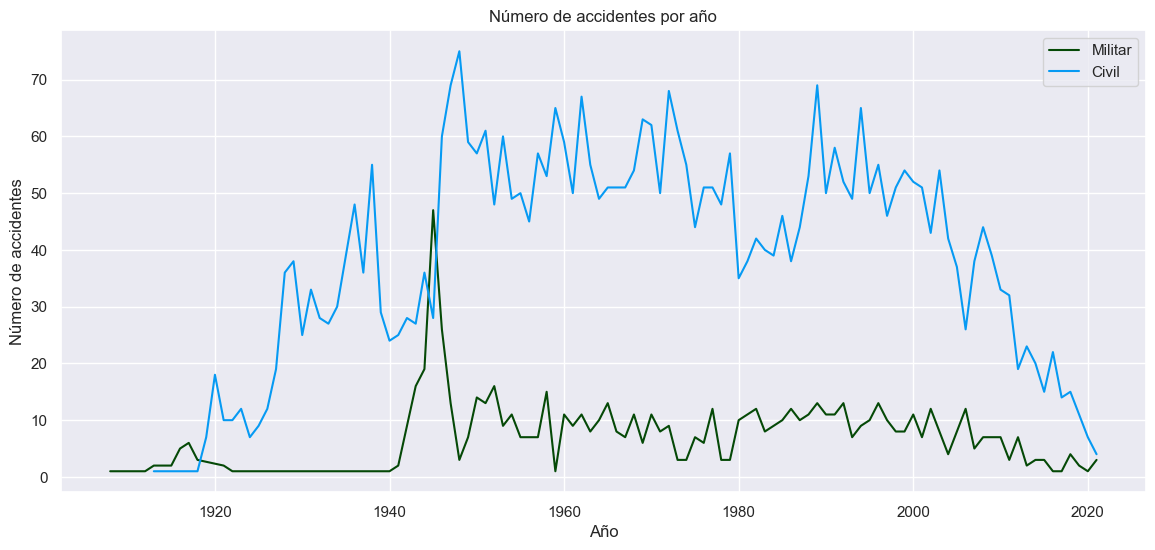

In [57]:

plt.figure(figsize=(14, 6))
sns.lineplot(data=cuentam, x='index', y='anio', color='xkcd:darkgreen',label='Militar')
sns.lineplot(data=cuentac, x='index', y='anio',color='xkcd:azure',label='Civil')
plt.xlabel('Año')
plt.ylabel('Número de accidentes')
plt.title('Número de accidentes por año')
plt.legend()
plt.show()

Como podemos apreciar la gráfica anterior, en los tiempos donde se vivieron la primera y segunda guerra mundial, los accidentes aéreos militares aumentaron y superaron los accidentes civiles, lo cual tiene total sentido, teniendo en cuenta que las fuerzas aéreas jugaron un papel de suma importancia en ambos conflictos. Justo después del pico que corresponde a los años de la segunda guerra mundial, vemos un aumento significativo en accidentes civiles, lo cual concuerda con la época en la que las aerolineas comerciales se comenzaron a volver más populares y los tiquetes más económicos.

columna: tipo_aeronave

El modelo Douglas DC-3 parece ser el que más ha tenido accidentes historicamente, este modelo tuvo un alto impacto en la industria aérea durante las decadas de 1930, 1940 y la segunda guerra mundial (cita). Estos aviones fueron adoptados tanto por industría aérea civíl como por la militar y se adaptaron varias versiones dependiendo el uso. Esto concuerda con las gráficas analizadas anteriormente, donde se pudo evidenciar una alta incidencia de accidentes después de 1940. Cabe resaltar que este tipo de aviones ya no son tan comúnes, no se siguen produciendo y los pocos que quedan, suelen ser usados como aviones de carga. Este también es el caso para los aviones que se encuentran en el top 10 de accidentes de este dataset, la mayoría son modelos viejos, pequeños y fabricados por la Douglas Aircraft Company, que tuvieron su mayor impacto en tiempos de guerra y desarrollo principal de la aviación comercial. Es tanto así que esta compañia actualmente no existe, ya que se fusionó en 1967 con McDonnell Aircraft y luego, en 1997 con Boeing, razón por la cual el logo de Boeing que conocemos actualmente es el mismo que solía tener Douglas.

columna: total_abordo

Teniendo en cuenta el reporte, la información es concluyente con lo que observamos en la columna anterior, la mayoría de accidentes en este dataset corresponden a modelos viejos que eran significativamente pequeños en comparación a los aviones comerciales que conocemos hoy en día, por lo tanto, tenemos que la mayor cantidad de accidentes tenían pocas personas a bordo. 

columna: pasajeros_abordo

Según el reporte, el valor más común de pasajeros a bordo es 0, esto se puede explicar porque no todos accidentes registrados aquí son de aviones comerciales. Seguido al 0, podemos ver que los otros registros más comunes en el top 10 no superan 10 pasajeros. Esto es consecuente con la información anteriormente registrada. 

columna: tripulacion_abordo

Los números de personas pertenecientes a la tripulación más comunes se encuentran entre 3 y 5, lo cual diría que es lo usual para varios sectores de la indutría aérea. 

In [58]:
df['tripulacion_abordo']=df['tripulacion_abordo'].astype('float')

Quiero revisar los valores atípicos de esta categoría, que los tomaré como los que estan por encima de 25, que según el reporte son los valores más grandes. 

In [59]:
df[df['tripulacion_abordo']>25]

fecha hora_declarada                         ruta  \
6    1915-03-05       01:00:00              Tienen, Belgium   
58   1921-08-24       17:40:00        River Humber, England   
100  1925-09-03       05:30:00               Caldwell, Ohio   
359  1935-02-12            NaT   Off Point Sur, Californiia   
455  1937-05-06       19:25:00        Lakehurst, New Jersey   
2453 1970-03-16       11:30:00  Near Da Nang, South Vietnam   
2884 1977-03-27       17:07:00     Tenerife, Canary Islands   
3009 1979-06-07       11:00:00              Near Leh, India   
4035 1996-11-12       18:40:00    Near Charkhi Dadri, India   

                                          operador  \
6                           Military - German Navy   
58                  Military - Royal Airship Works   
100                           Military - U.S. Navy   
359                             Military - US Navy   
455                     Deutsche Zeppelin Reederei   
2453                          Military - U.S. Navy   
2884              Pan American World Airways / KLM   
3009                   Military - Indian Air Force   
4035  Saudi Arabian Airlines / Kazakhstan Airlines   

                                 tipo_aeronave total_abordo pasajeros_abordo  \
6                       Zeppelin L-8 (airship)           41                0   
58          Royal Airship Works ZR-2 (airship)           49                0   
100        Dirigible ZR-1 Shenandoah (airship)           43                0   
359   Goodyear-Zeppelin U.S.S. Macon (airship)           83                0   
455                            Zeppelin LZ-129           97               36   
2453                          Lockheed EC-121P           31                0   
2884      Boeing B-747-121 / Boeing B-747-206B          644              614   
3009              Hindustan Aeronautics 748-2M           27                0   
4035      Boeing B-747-168B / Ilyushin IL-76TD          349              316   

      tripulacion_abordo total_fatalidades pasajeros_fatalidades  \
6                   41.0                17                     0   
58                  49.0                43                     0   
100                 43.0                14                     0   
359                 83.0                 2                     0   
455                 61.0                35                    13   
2453                31.0                23                     0   
2884                30.0               583                   560   
3009                27.0                27                     0   
4035                33.0               349                   316   

     tripulacion_fatalidades tierra_fatalidades  anio  
6                         17                  0  1915  
58                        43                  1  1921  
100                       14                  0  1925  
359                        2                  0  1935  
455                       22                  1  1937  
2453                      23                  0  1970  
2884                      23                  0  1977  
3009                      27                  0  1979  
4035                      33                  0  1996

Como se puede apreciar, estos valores corresponden en su mayoría a Zeppelins militares en los que todos a bordo son considerados tripulación y los que son civiles, son vuelos comerciales en los que hubo colisión en el aire de dos aviones así que se suman los valores de ambos. 

columnas: total_fatalidades y tierra_fatalidades 


In [60]:
df['total_fatalidades']=df['total_fatalidades'].astype('int')
df['tierra_fatalidades']=df['tierra_fatalidades'].astype('float')

In [61]:
fat_abordo_anio=df.groupby('anio')['total_fatalidades'].sum().reset_index()

In [62]:
fat_tierra_anio=df.groupby('anio')['tierra_fatalidades'].sum().reset_index()

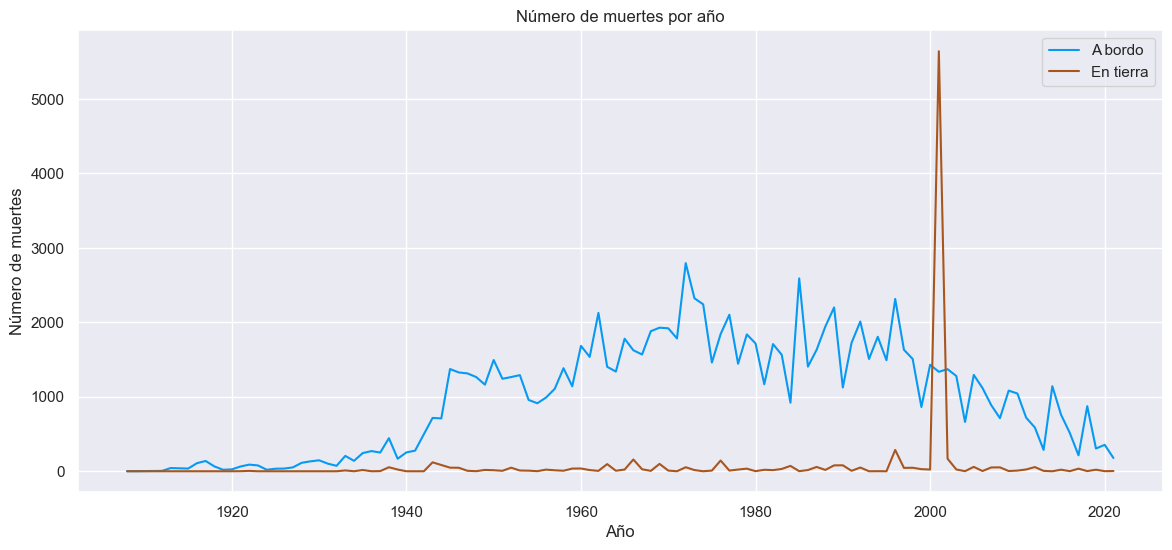

In [63]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=fat_abordo_anio, x='anio', y='total_fatalidades', color='xkcd:azure',label='A bordo')
sns.lineplot(data=fat_tierra_anio, x='anio', y='tierra_fatalidades',color='xkcd:sienna',label='En tierra')
plt.xlabel('Año')
plt.ylabel('Número de muertes')
plt.title('Número de muertes por año')
plt.legend()
plt.show()

Como vemos en esta gráfica, realmente es raro que haya mucho muertos en tierra cuando un avión se accidenta,sin embargo, podemos ver que hay un pico de fatalidades en tierra en el año 2001, esto corresponde al ataque terrorista al World Trade Center (9/11), en el cual dos aviones chocaron contra sus dos torres, las cuales estaban llenas de personas en la ciudad de Nueva York. A continuación el detalle de estos valores atípicos.

In [64]:
df[df['tierra_fatalidades']>2000]

fecha hora_declarada                     ruta           operador  \
4324 2001-09-11       08:47:00  New York City, New York  American Airlines   
4325 2001-09-11       09:03:00  New York City, New York   United Air Lines   

         tipo_aeronave total_abordo pasajeros_abordo  tripulacion_abordo  \
4324  Boeing 767-223ER           92               81                11.0   
4325  Boeing B-767-222           65               56                 9.0   

      total_fatalidades pasajeros_fatalidades tripulacion_fatalidades  \
4324                 92                    81                      11   
4325                 65                    56                       9   

      tierra_fatalidades  anio  
4324              2750.0  2001  
4325              2750.0  2001

Segun el reporte, para este dataset, el valor mas comun de fatalidades es 1 y en el top 10 le siguen valores en el rango de 2 a 13. Esto es congruente con las conclusiones que se extrajeron previamente de las otras columnas. 

In [65]:
fat_abordo_anio[fat_abordo_anio['total_fatalidades']>2600]

anio  total_fatalidades
61  1972               2796

El año con mayor número de fatalidades parece ser 1972, lo cual tiene sentido porque en 1972 ya estaba operando la nueva generación de jets, que hasta el día de hoy siguen en uso y en producción, como el Boeing 737. Estos aviones son mucho más grandes que los de la primera generación y admiten muchos más pasajeros, por ende, en el caso de accidentes, lo más probable es que haya una mayor tasa de mortalidad, aunque no necesariamente haya una mayor tasa de accidentalidad. De hecho, según la literatura, la tasa de accidentes fatales por millón de vuelos de 3 para la primera generación de jets, cayó a un 0.9 para la segunda generación y ha seguido cayendo para las generaciones siguientes(cita).

## KPI solicitado

In [66]:
df['total_abordo']=df['total_abordo'].astype('int')

In [67]:
tot_abordo_anio=df.groupby('anio')['total_abordo'].sum().reset_index()

In [68]:
tasamortan=fat_abordo_anio.merge(tot_abordo_anio, on='anio', how='outer')

In [69]:
tasamortan['tasa_mortalidad_anual']=tasamortan['total_fatalidades'].divide(tasamortan['total_abordo'])

In [70]:
tasamortan

anio  total_fatalidades  total_abordo  tasa_mortalidad_anual
0    1908                  1             2               0.500000
1    1909                  1             1               1.000000
2    1912                  5             5               1.000000
3    1913                 43            49               0.877551
4    1915                 36            60               0.600000
..    ...                ...           ...                    ...
106  2017                214           245               0.873469
107  2018                874          1239               0.705408
108  2019                305           432               0.706019
109  2020                355           703               0.504979
110  2021                178           227               0.784141

[111 rows x 4 columns]

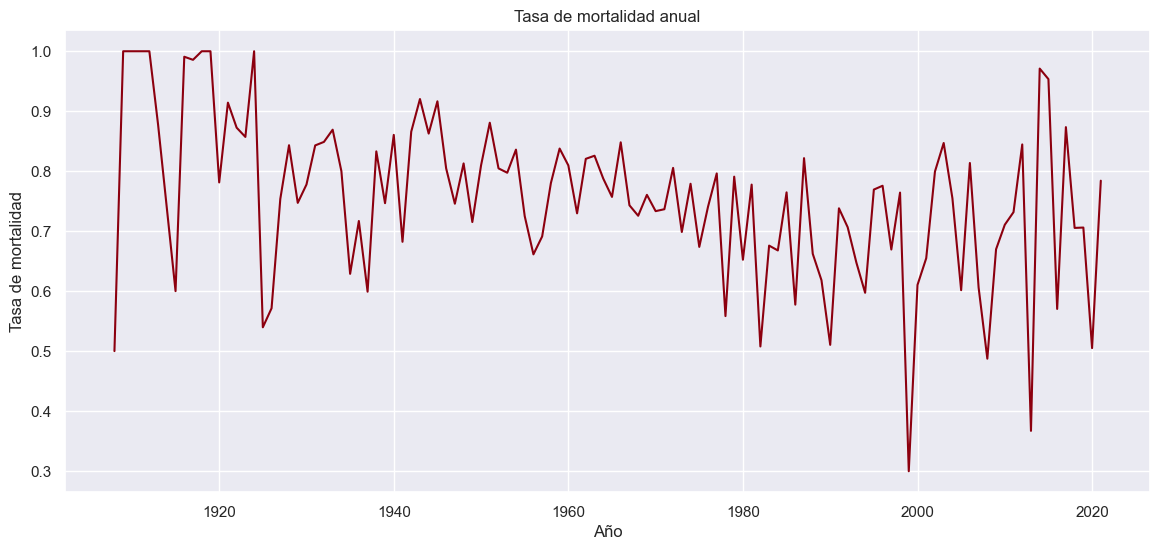

In [71]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=tasamortan, x='anio', y='tasa_mortalidad_anual', color='xkcd:crimson')
plt.xlabel('Año')
plt.ylabel('Tasa de mortalidad')
plt.title('Tasa de mortalidad anual')
plt.show()

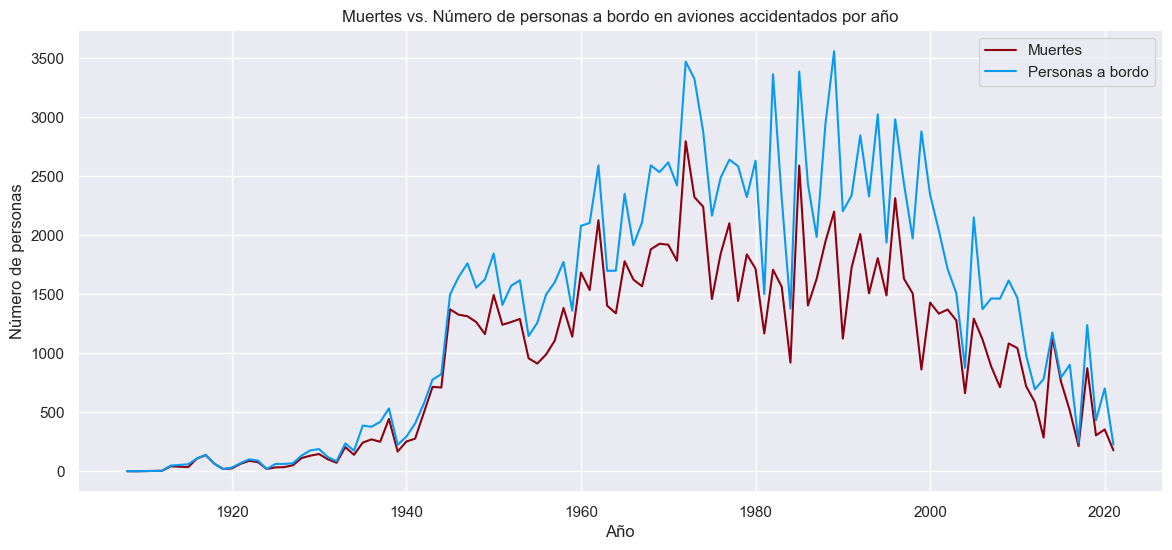

In [72]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=tasamortan, x='anio', y='total_fatalidades', color='xkcd:crimson',label='Muertes')
sns.lineplot(data=tasamortan, x='anio', y='total_abordo', color='xkcd:azure',label='Personas a bordo')
plt.xlabel('Año')
plt.ylabel('Número de personas')
plt.title('Muertes vs. Número de personas a bordo en aviones accidentados por año')
plt.show()

## KPIs propuestos

**Tasa anual de fataliades por accidentes**

El objetivo para los próximos 5 años es disminuir por lo menos en un 30% la tasa de fatalidades por accidente.
Numero de fallecidos en los accidentes aereos en relacion al numero total de accidentes registrados. 

In [73]:
accidents_by_year = df.groupby('anio')['fecha'].count().reset_index()

In [74]:
tasamortan=tasamortan.merge(accidents_by_year, on='anio',how='outer')

In [75]:
tasamortan.rename(columns={'fecha':'accidentes_anio'},inplace=True)

In [76]:
tasamortan['fatalidades_accidentes']=tasamortan['total_fatalidades'].divide(tasamortan['accidentes_anio'])

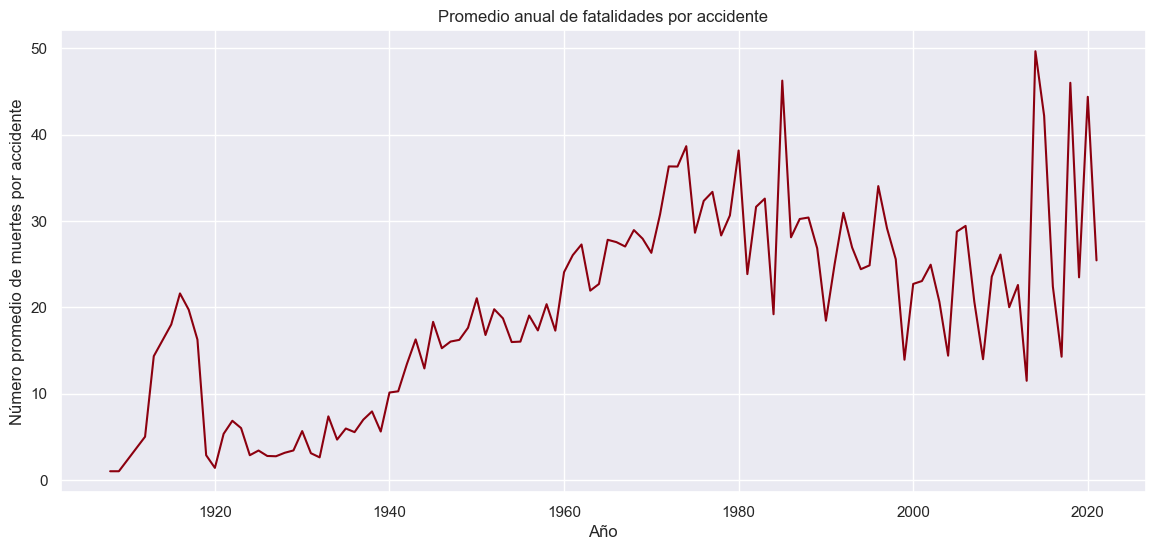

In [77]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=tasamortan, x='anio', y='fatalidades_accidentes', color='xkcd:crimson')
plt.xlabel('Año')
plt.ylabel('Número promedio de muertes por accidente')
plt.title('Promedio anual de fatalidades por accidente')
plt.show()

In [78]:
df.isna().sum()

fecha                         0
hora_declarada             1484
ruta                          5
operador                     10
tipo_aeronave                11
total_abordo                  0
pasajeros_abordo            201
tripulacion_abordo          201
total_fatalidades             0
pasajeros_fatalidades       217
tripulacion_fatalidades     217
tierra_fatalidades           32
anio                          0
dtype: int64

**Accidentes fatales por total accidentes**

Numero de acidentes fatales(donde todos a bordo murieron) en relacion al numero total de accidentes por anio. El objetivo para los proximos 5 años es que la tasa de accidentes fatales por total de accidentes en el año se mantenga por debajo del 50%.

In [79]:
accnofatales=df[df['total_fatalidades']==0].groupby('anio')['total_fatalidades'].count().reset_index()
accfatales=df[df['total_fatalidades']==df['total_abordo']].groupby('anio')['total_fatalidades'].count().reset_index()
acctot=df.groupby('anio')['fecha'].count().reset_index()

In [80]:
acctot

anio  fecha
0    1908      1
1    1909      1
2    1912      1
3    1913      3
4    1915      2
..    ...    ...
106  2017     15
107  2018     19
108  2019     13
109  2020      8
110  2021      7

[111 rows x 2 columns]

In [81]:
acc=accfatales.merge(accnofatales,on='anio',how='outer')
acc=acc.merge(acctot,on='anio',how='outer')

In [82]:
acc.rename(columns={'total_fatalidades_x':'num_acc_fatales', 'total_fatalidades_y':'num_acc_nofatales', 'fecha':'total_acc'},inplace=True)
acc['num_acc_nofatales'].fillna(0,inplace=True)
acc['num_acc_fatales'].fillna(0,inplace=True)


In [83]:
acc['tasa_fatal']=acc['num_acc_fatales']/acc['total_acc']

In [84]:
acc=acc.sort_values(['anio'])
acc=acc.reset_index(drop=True)

In [85]:
acc

anio  num_acc_fatales  num_acc_nofatales  total_acc  tasa_fatal
0    1908              0.0                0.0          1    0.000000
1    1909              1.0                0.0          1    1.000000
2    1912              1.0                0.0          1    1.000000
3    1913              2.0                0.0          3    0.666667
4    1915              1.0                0.0          2    0.500000
..    ...              ...                ...        ...         ...
106  2017             12.0                0.0         15    0.800000
107  2018             11.0                0.0         19    0.578947
108  2019              9.0                0.0         13    0.692308
109  2020              3.0                0.0          8    0.375000
110  2021              4.0                0.0          7    0.571429

[111 rows x 5 columns]

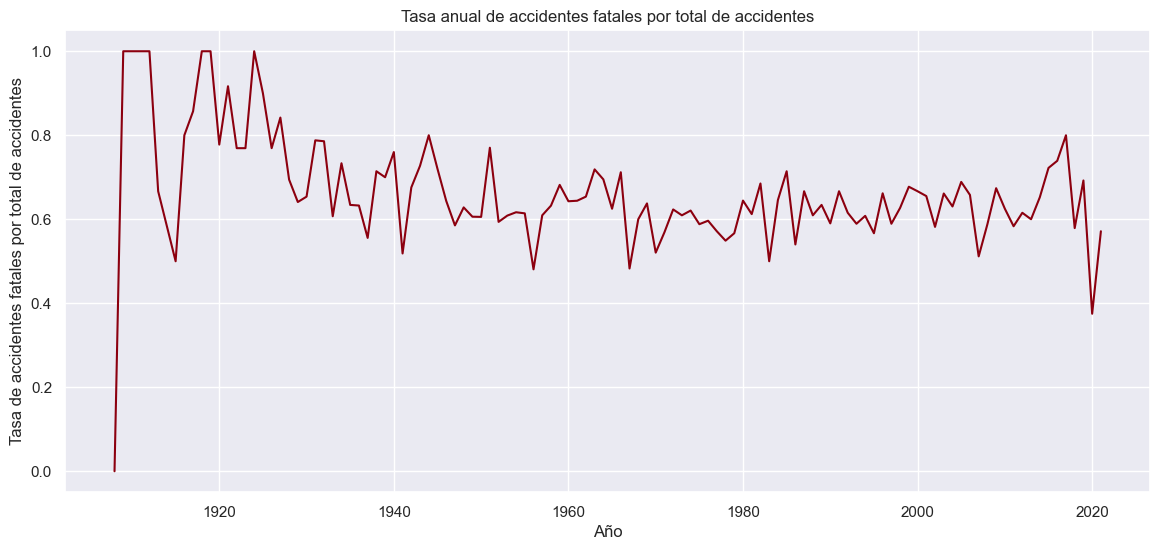

In [86]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=acc, x='anio', y='tasa_fatal', color='xkcd:crimson')
plt.xlabel('Año')
plt.ylabel('Tasa de accidentes fatales por total de accidentes')
plt.title('Tasa anual de accidentes fatales por total de accidentes')
plt.show()

Tasa de accidentes no fatales por accidente

Tasa de accidentes no fatales (en los que nadie murio) en relacion al numero total de accidentes. El objetivo para los proximos 5 años es que este KPI aumente en un 50%.

In [87]:
acc['tasa_no_fatal']=acc['num_acc_nofatales']/acc['total_acc']

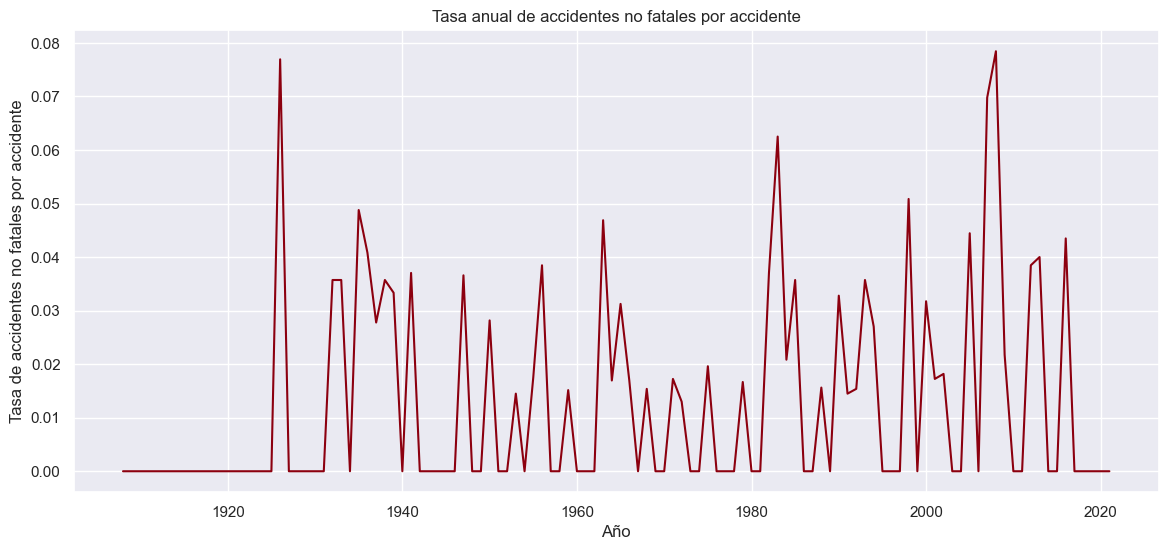

In [88]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=acc, x='anio', y='tasa_no_fatal', color='xkcd:crimson')
plt.xlabel('Año')
plt.ylabel('Tasa de accidentes no fatales por accidente')
plt.title('Tasa anual de accidentes no fatales por accidente')
plt.show()